In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:

adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-109\\V11L12-109_A1\\output_data\\V11L12-109_A1_MSI\\V11L12-109_A1.Visium.FMP.220826_smamsi.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-109\\V11L12-109_D1\\output_data\\V11L12-109_D1\\outs\\V11L12-109_D1.h5ad")

In [3]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 1463 × 14369
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 2438 × 1538
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '3578', '3579', '3580', '3581', '3582', '3583', '3584', '3585', '3586',
       '3587'],
      dtype='object', 

In [4]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [5]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

selected_indices = np.random.choice(2438, 1463, replace=False)

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
#data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)


<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
609  -0.450980 -0.117647
1355  0.058824 -0.823529
993  -0.215686  0.823529
2245  0.725490 -0.264706
842  -0.294118 -0.088235
...        ...       ...
164  -0.803922  0.323529
2091  0.607843 -0.911765
1021 -0.176471 -0.117647
329  -0.647059 -0.323529
861  -0.294118  0.470588

[1463 rows x 2 columns]>


In [6]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results_cca = cca.transform(data1_spatial_results)
data2_spatial_results_cca = cca.transform(data2_spatial_results)
data3_spatial_results_cca = cca.transform(data3_spatial_results)
data1_spatial_results_cca=pd.DataFrame(data1_spatial_results_cca)
data2_spatial_results_cca=pd.DataFrame(data2_spatial_results_cca)
data3_spatial_results_cca=pd.DataFrame(data3_spatial_results_cca)

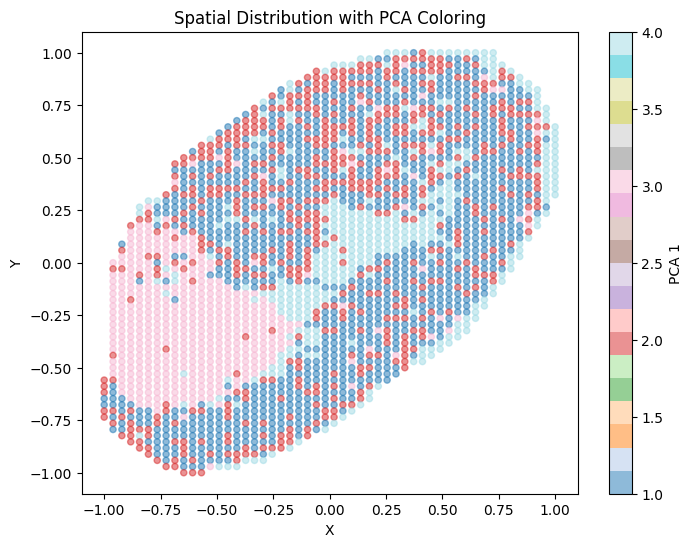

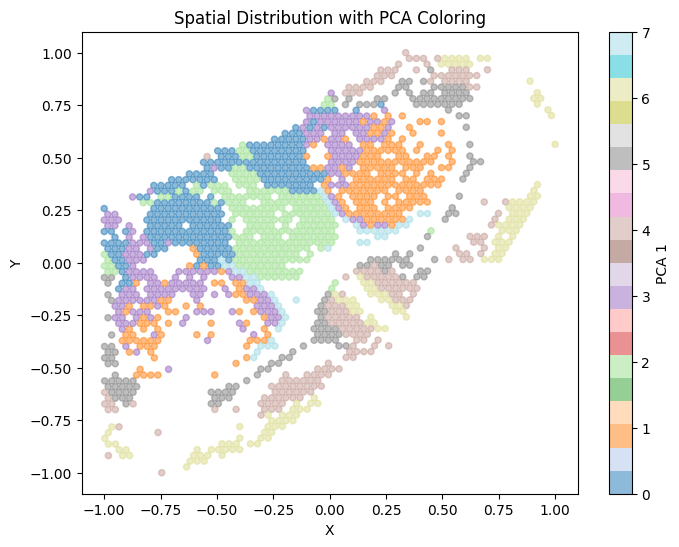

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [8]:
####select nearst neighbour of sample pairs between X1 and X3
####
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}
Y_c = data2_spatial_results_cca
Z_c = data3_spatial_results_cca
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())


(2438, 2) (1463, 2)
(2438, 1463)
(2438, 2) (1463, 2)
(2438, 2) (1463, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0      -2.229495      -1.771847           0                4             -1   
1       0.077094      -1.597385           1                2             -1   
2       1.172146       1.917047           2                6             -1   
3       0.003624      -1.108480           3                0             -1   
4       0.665926      -0.565216           4                2             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0        -2.161552        -1.722787           272                  2   
1         0.085727        -1.614622           143                  4   
2         1.166897         1.899951          2319                  1   
3        -0.008415        -1.130973           442                  1   
4         0.647990        -0.556082           772                  2   

   matabolic.CCA.Z 

C:\Users\28123\AppData\Local\Temp\ipykernel_7112\2496822887.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index


C:\Users\28123\AppData\Local\Temp\ipykernel_7112\1707236285.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


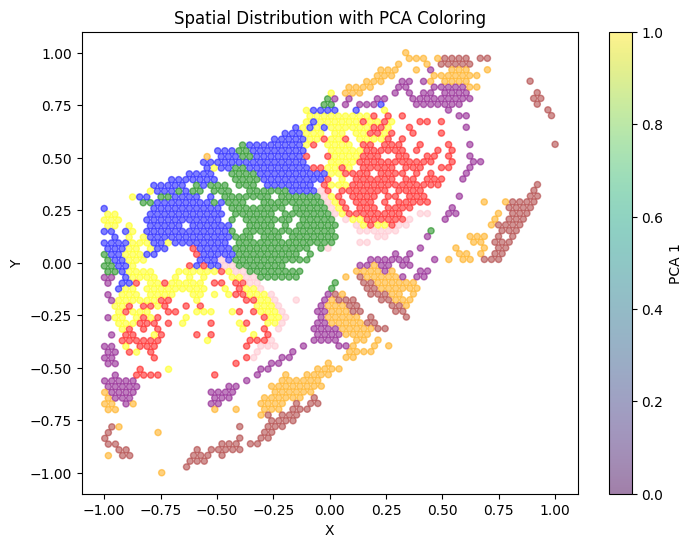

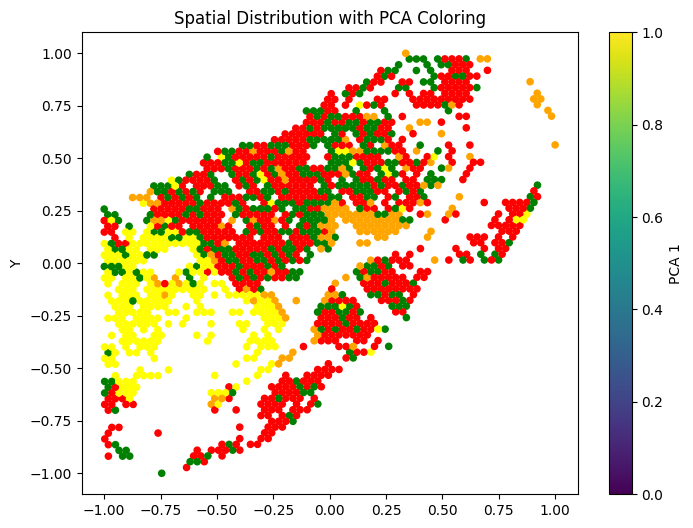

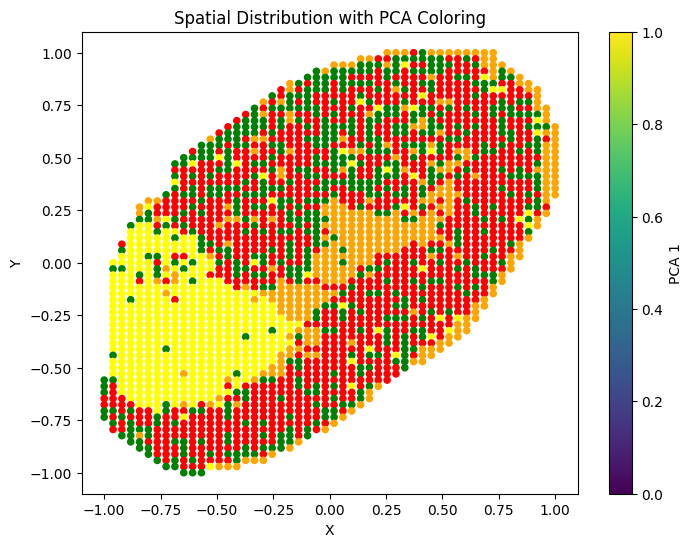

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()